<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/stage1-rerun/1_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 1 - Data preparation

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** To create a clean and well-structured multilingual dataset of news articles with enriched metadata, optimized for efficient indexing and retrieval in a future RAG-based system.

# 1. Loading, Parsing, and Cleaning HTML Files

## 1.1 Setup of the environment

### Installations and loading of packages

Below the necessary libraries are installed and loaded into the environment.

In [1]:
!pip install -q beautifulsoup4==4.13.4
!pip install -q docling==2.31.0
from bs4 import BeautifulSoup, Comment
import docling
from docling.document_converter import DocumentConverter, InputFormat, HTMLFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import AcceleratorDevice, AcceleratorOptions
from docling.datamodel.pipeline_options import PipelineOptions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.1/166.1 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 36.6 MB/s eta 0:00:00
   ━━

In [2]:
import os
import re
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile

### Setting seeds and mounting Google Drive storage folder

In [3]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

Below we mount a shared Google Drive folder as a data storage and define the base path of the folder that will be used in the runtime.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

### Check properties of environment

In [6]:
!nvidia-smi

Wed May 21 08:29:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   36C    P8             17W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.6.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.6
ale-py                                0.11.0
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.0.2
astropy-iers-data                     0.2025.5.12.0.38.29
astunparse                            1

## 1.2. Loading the raw data

### Loading

We go through the subdirectories inside the data-folder. Inside those folders the individual html-files will be read and the content will be saved together with the information of the file-name and the path of the file (to store in which subfolder it was located).

In [8]:
# Definition of data folder
data_folder = os.path.join(base_folder, 'data')

In [10]:
# List to hold the dictionaries
data = []

# Walk through all directories and subdirectories
for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith('.html'):
            file_path = os.path.join(root, file)

            # Read the content of the HTML file
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()

            # Add a dictionary to the list
            data.append({
                'folder_path': root,
                'file_name': file,
                'full_path': file_path,
                'html_content': content
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Show first rows to verify
print(df.head())

                                         folder_path  \
0  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
1  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
2  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
3  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
4  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   

                                  file_name  \
0             blog-knutti-klimamodelle.html   
1  scientifica-teaser-kerosin-aus-luft.html   
2            kraftwerk-vor-dem-fenster.html   
3                 eth-plus-initiativen.html   
4   kuenstliche-intelligenz-im-podcast.html   

                                           full_path  \
0  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
1  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
2  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
3  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   
4  /content/drive/MyDrive/AdvGenAI/data/de_news_e...   

                                        htm

In [11]:
pd.set_option('display.max_colwidth', 50)
df.head()

,folder_path,file_name,full_path,html_content
0,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,"<div class=""text-image cq-dd-image"">\n<figure ..."
1,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,scientifica-teaser-kerosin-aus-luft.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,"<div class=""text-image cq-dd-image"">\n<p>Viele..."
2,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kraftwerk-vor-dem-fenster.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,"<div class=""text-image cq-dd-image"">\n<p>Gebäu..."
3,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,eth-plus-initiativen.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,"<div class=""text-image cq-dd-image"">\n<p>Das I..."
4,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kuenstliche-intelligenz-im-podcast.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,"<div class=""text-image cq-dd-image"">\n<p>Künst..."


In [13]:
print(df.iloc[5:10, 2].values)

['/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/ein-feines-gehoer-fuer-zeitreisen-oder-wie-die-zeiten-wirklich-ticken.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/quantencomputer-und-die-zukunft-des-berechenbaren.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/drei-d-gedrucktes-salztemplate.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/mensch-und-technik-im-hauptbahnhof.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/eth-spinoff-spectroplast.html']


In [14]:
print(df.iloc[-10:-1, 2].values)

['/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/cleverer-kleber-koppelt-zugseil-und-motorprotein.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/an-eye-on-reconstruction-in-ukraine-with-recycled-concrete.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/acids-help-against-airborne-viruses.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/nasa-insight-lander-has-retired.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/looking-back-at-2022.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/globe-new-approaches-to-waste-management.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/nccr-qsit-switzerland-could-play-a-key-role.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/blog-ecology-as-the-guiding-discipline-of-the-future.html'
 '/content/drive/MyDrive/AdvGenAI/data/en_news_events/2022/12/looking-back-podcast.html']


### Checking completeness of loading

**Number of files**

Below we compare the number of documents collected by the function into the Dataframe with a selection of all files in the data folder.

In the check 3 files were discovered that were not part of the dataframe. After inspection it was discovered that those are `.DS_Store`file, for which it makes sense that they were not included.

In [15]:
# Dataframe
print(f"Number of files in the DataFrame: {len(df)}")

Number of files in the DataFrame: 4390


In [16]:
# Files in Data folder
print(f"Number of files in the data folder:")
!find "$data_folder" -type f | wc -l

Number of files in the data folder:
4393


In [17]:
!find "$data_folder" -type f | sort > folder_files.txt
df['full_path'].sort_values().to_csv('df_files.txt', index=False, header=False)
!sort folder_files.txt -o folder_files.txt
!sort df_files.txt -o df_files.txt
!comm -23 folder_files.txt df_files.txt

/content/drive/MyDrive/AdvGenAI/data/de_internal/2013/.DS_Store
/content/drive/MyDrive/AdvGenAI/data/de_internal/2015/.DS_Store
/content/drive/MyDrive/AdvGenAI/data/de_internal/2024/.DS_Store


**Checking for empty files**

Below we print out the rows of the dataframe with empty contents.

In [22]:
print(f"Files with no content: {len(df[df['html_content']==''])}")
df[df['html_content']==""].head()

Files with no content: 32


,folder_path,file_name,full_path,html_content
265,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,einstein-quiz.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,
900,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,pp_pitch_elgar_fleisch.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,
1098,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,annette-oxenius-erhaelt-cloetta-preis.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,
1102,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,kleider-virtuell-anprobieren.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,
1103,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,neue-daten-sprechen-fuer-magma-auf-dem-mars.html,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,


In [23]:
print(df.loc[df['html_content']=="", "full_path"].values)

['/content/drive/MyDrive/AdvGenAI/data/de_news_events/2021/08/einstein-quiz.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2016/08/pp_pitch_elgar_fleisch.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10/annette-oxenius-erhaelt-cloetta-preis.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10/kleider-virtuell-anprobieren.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/10/neue-daten-sprechen-fuer-magma-auf-dem-mars.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/11/proteinformen-zeigen-parkinson-krankheit-an.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/11/kunst-aus-dem-computer.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2022/09/elektroflugzeug-e-sling-hebt-ab.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2023/02/besser-verstehen-wie-die-blut-hirn-schranke-funktioniert.html'
 '/content/drive/MyDrive/AdvGenAI/data/de_news_events/2023/02/wo-giftstoffe-aus-taba

After checking the files in the original data source we concluded that those files were empty files and therefore it was not a problem in the process of the data loading. We therefore exclude those rows from the dataframe.

In [24]:
len(df)

4390

In [25]:
df = df[~df['html_content'].isna()].copy()
df = df[~(df['html_content']=="")].copy()

In [26]:
len(df)

4358

In [28]:
print(df.shape)  # Output: (rows, columns)
print(df.columns)  # List all column names

(4358, 4)
Index(['folder_path', 'file_name', 'full_path', 'html_content'], dtype='object')


### Saving the data to storage

In [29]:
# Saving the Dataframe to the Google Drive storage
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-01-raw-data.csv'), index=False)

## 1.3 Parsing and cleaning the HTML files

### Loading the data from storage

In [30]:
# Load csv from Google Drive Storage to Dataframe
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-01-raw-data.csv'))

Below we print some of the html contents.

In [31]:
pd.set_option('display.max_colwidth', 300)
df[["html_content"]].head(5)

,html_content
0,"<div class=""text-image cq-dd-image"">\n<figure class=""text-image__image text-image__image--small"">\n<img alt=""Reto Knutti"" src=""/de/news-und-veranstaltungen/eth-news/news/2019/08/blog-knutti-klimamodelle/_jcr_content/news_content/textimage/image.imageformat.textsingle.2119973012.png""/>\n</figure>..."
1,"<div class=""text-image cq-dd-image"">\n<p>Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. Manches könnte aber in Zukunft als selbstverständlich gelten. An der Scientifica präsentieren Ihnen Forschend..."
2,"<div class=""text-image cq-dd-image"">\n<p>Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon sparen. Ein an der ETH Zürich entwickeltes System verwendet bewegliche Solarpanels, die Strom produzieren und zugleich genau so viel Sonne durchlassen oder..."
3,"<div class=""text-image cq-dd-image"">\n<p>Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist nach wie vor gross: 241 ETH-Ange­hörige haben sich an der zweiten Runde beteiligt, und sie stammen aus allen Departementen und Bereichen der ETH. 25 Ide..."
4,"<div class=""text-image cq-dd-image"">\n<p>Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Licht sehen. Im Podcast sprechen wir mit den ETH-Professoren Benjamin Grewe, Simone Schürle und Thomas Hofmann über Vorteile und auch Gefahren der Künstli..."


### BeautifulSoup

#### Definition of cleaning function

Below a function is defined to clean the stored strings of the html-files using `BeautifulSoup`. It extracts the title and main texts of the documents while removing various elements that are not of interest for the further analysis (for example style and navigation elements).

The different sections of the content are separated by `\n\n`

In [32]:
def clean_html(html_content):
    from bs4 import BeautifulSoup, Comment
    import re

    soup = BeautifulSoup(html_content, 'html.parser')

    # Title extraction
    title = soup.title.get_text(strip=True) if soup.title else ''

    # Remove unwanted elements
    for el in soup(['script', 'style', 'header', 'footer', 'nav', 'iframe', 'meta', 'link']):
        el.decompose()
    for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
        comment.extract()

    # Replace <br> with newline
    for br in soup.find_all("<br/>"):
        br.replace_with("\n")

    # Get the content from body if exists
    content = soup.body or soup

    # get_text with separator
    clean_text = content.get_text(separator='\n\n').strip()

    # Post-process: Collapse excessive blank lines
    clean_text = re.sub(r'\n{3,}', '\n\n', clean_text)

    return title, clean_text

#### Application of cleaning function on subset

In the cells below we apply the cleaning function of BeautifulSoup on a subset of the data for illustration.

In [33]:
# create a subset of the dataframe for testing
df_test = df.sample(n=5).copy()

In [34]:
df_test['title'], df_test['clean_content'] = zip(*df_test['html_content'].apply(clean_html))

In [35]:
pd.set_option('display.max_colwidth', 150)
df_test[['html_content', 'title', 'clean_content']].head()

,html_content,title,clean_content
1302,"<div class=""text-image cq-dd-image"">\n<h2>In Kürze</h2>\n<ul>\n<li>In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbar...",,"In Kürze\n\nIn Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbares Ultrabreitband-Tracking-System, um in Spitälern die ..."
281,"<div class=""text-image cq-dd-image"">\n<p><b>Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzu...",,"Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzunterricht angekündigt. Da werden die Studier..."
1632,"<div class=""text-image cq-dd-image"">\n<p>Die Aufgabenstellung des öffentlichen anonymen Projektwettbewerbs war nicht einfach: Das MM unter der Pol...",,Die Aufgabenstellung des öffentlichen anonymen Projektwettbewerbs war nicht einfach: Das MM unter der Polyterrasse sollte eine eigene erkennbare A...
3973,"<div class=""text-image cq-dd-image"">\n<p>As society becomes more digitalised, institutions need more and more data science skills. This includes t...",,"As society becomes more digitalised, institutions need more and more data science skills. This includes the integration of tools arising from arti..."
2310,"<div class=""text-image cq-dd-image"">\n<p>The Executive Board is upgrading the status of the <a class=""eth-link"" href=""/en/die-eth-zuerich/strategi...",,The Executive Board is upgrading the status of the \n\nCritical Thinking\n\n (CTETH) Initiative from a project to a permanent structure. After ETH...


Below we print out the HTML and the cleaned content for each document for comparison. For the cleaned content the double newlines are replaced by `\n---PARAGRAPH BREAK---\n` for better readability.

In [ ]:
# @title  {"display-mode":"code"}
from IPython.display import HTML
for idx, row in df_test.iterrows():
    print("-" * 100)
    print(f"Row {idx}:")
    display(HTML(row['html_content']))
    # Display the cleaned text
    print("\nCleaned Text:\n")
    print(row['clean_content'].replace('\n\n', '\n---PARAGRAPH BREAK---\n'))
    print(100 * "-")
    print("\n")

----------------------------------------------------------------------------------------------------
Row 1302:



Cleaned Text:

In Kürze
---PARAGRAPH BREAK---
In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbares Ultrabreitband-Tracking-System, um in Spitälern die Nahkontakte in Infektionsnetzwerken genauer nachzuverfolgen.
---PARAGRAPH BREAK---
Das Forschungsteam testete ein Gerät, das die Kontaktabstände zwischen Krankenhausmitarbeitenden erfasst, in der Schweiz, in Kenia und an der Elfenbeinküste.
---PARAGRAPH BREAK---
Die Ergebnisse helfen bei der Untersuchung potenzieller Gefahrenherde und der Auswirkung verschiedener Maskentypen auf die Infektionsausbreitung sowie bei der Anpassung von Technologien und Verfahren an kulturelle Unterschiede.
---PARAGRAPH BREAK---
Im Krankenhaus erworbene Infektionen sind ein grosses Problem. «Während der Covid-Pandemie traten oft Ansteckungen in Spitälern auf. Das gefährdete nicht nur geschwächte Patient:innen, sondern viele Einrichtungen bekamen auch grosse Personalprobleme, weil zahlreiche Mitarbeitende gleichzeitig erkrankten»,


Cleaned Text:

Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzunterricht angekündigt. Da werden die Studierenden aufatmen. Allerdings ist von «neuer Präsenz» die Rede. Was genau ist darunter zu verstehen?
---PARAGRAPH BREAK---
 Nach drei Semestern Online-Unterricht setzen wir alles daran, das Herbstsemester grundsätzlich in Präsenz durchführen zu können. Insbesondere aktives Lernen, Übungen und experimentelle Lehre sollen auf dem Campus stattfinden. Dafür sehen wir die normalen Belegungsdichten vor. Gleichzeitig wollen wir aber die innovativen Online-Lehrformen beibehalten und sogar ausbauen. Wir gehen also nicht zurück zur Präsenzlehre, wie wir sie vor dem Ausbruch der Pandemie kannten.
---PARAGRAPH BREAK---
Sind aktuell die Voraussetzungen für einen Präsenzunterricht gegeben?
---PARAGRAPH BREAK---
 Die derzeitigen Bestimmungen des Bundesrates erlauben eine Rückkehr zur Präsenz, sofern Hochschulen über ein Schutzkonzept verfügen u


Cleaned Text:

Die Aufgabenstellung des öffentlichen anonymen Projektwettbewerbs war nicht einfach: Das MM unter der Polyterrasse sollte eine eigene erkennbare Adresse erhalten, ohne den Charakter des benachbarten ETH-Hauptgebäudes zu beeinträchtigen. Mehr Raum und Funktionalität für Sport und Gastronomie sollte der Projektvorschlag ebenfalls generieren. Zudem hiess es, die Orientierung innerhalb des Gebäudes sowie die Aufenthaltsqualität nicht nur der Aussichtsterrasse zu stärken. Der zwingende Sanierungsbedarf des Gebäudes, insbesondere der Gebäudetechnik, war neben weiteren Mängeln Auslöser des Wettbewerbs.
---PARAGRAPH BREAK---
Eine zwölfköpfige Jury hat das Projekt der Ballmoos Krucker Architekten AG aus insgesamt acht Wettbewerbsbeiträgen ausgewählt. Positiv bewertet wurde unter anderem die Einbettung in die Landschaft, die Lenkung des Fussgängerströme, die Aufwertung der Unterführung und das Nachhaltigkeitskonzept.
---PARAGRAPH BREAK---
Alle Wettbewerbsbeiträge sind vom 26. Apr


Cleaned Text:

As society becomes more digitalised, institutions need more and more data science skills. This includes the integration of tools arising from artificial intelligence in a way that is safe and beneficial to society as a whole. To this end, as a pioneer within the federal administration, the FSO is teaming up with the Swiss Data Science Center (SDSC), a joint venture between the two federal institutes of technology.
---PARAGRAPH BREAK---
“I am extremely enthusiastic about this strategic partnership in a joint flagship project between our two institutes and the FSO”, said Martin Vetterli, President of the EPFL. “It reminds me of the partnership between the Alan Turing Institute in London and the British Office for National Statistics, committed to a joint vision of research and innovation in regard to data science.”
---PARAGRAPH BREAK---
Three strands of cooperation
---PARAGRAPH BREAK---
The first strand of cooperation is to strengthen the FSO's Data Science Competence Cen


Cleaned Text:

The Executive Board is upgrading the status of the 
---PARAGRAPH BREAK---
Critical Thinking
---PARAGRAPH BREAK---
 (CTETH) Initiative from a project to a permanent structure. After ETH Professor Gerd Folkers has already done a good job building up the initiative since 2013, a member of the Executive Board will now take charge. This person will lead a  permanent CTETH team that will report to the Rector and build a network of contact persons in the academic and administrative departments, as well as the staff units. Support will also come from a ‘sounding board’ consisting of representatives from the departments, university groups and central bodies. Teaching events, project support and a regularly published reader will encourage critical thinking among students and employees, which is a vital element of academic culture.
---PARAGRAPH BREAK---
 
---PARAGRAPH BREAK---
Ten new professors thanks to the Hanna Böhi Fund
---PARAGRAPH BREAK---
One of President Mesot’s stated go

The double newlines between header and text are not optimal. Additionally the bullet point lists are not captured as such. Improvements would be possible but we decided to try if Docling handles the conversion already better with the predefined settings.

Another thing to note is parts of the texts don't give any useful information, such as the "Subscribe to Newsletter" and the "Staffnet" chapter or endings such as the following one: "externe Seite 10.1002/smj.2221 call_made"

#### Application of cleaning function on full Dataframe

Below we apply the conversion to all documents.

In [37]:
df['bs_html_title'], df['bs_html_content'] = zip(*df['html_content'].apply(clean_html))

In [38]:
pd.set_option('display.max_colwidth', 150)
df[['html_content', 'bs_html_title', 'bs_html_content']].head(5)

,html_content,bs_html_title,bs_html_content
0,"<div class=""text-image cq-dd-image"">\n<figure class=""text-image__image text-image__image--small"">\n<img alt=""Reto Knutti"" src=""/de/news-und-verans...",,"Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Compute..."
1,"<div class=""text-image cq-dd-image"">\n<p>Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtägl...",,"Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. ..."
2,"<div class=""text-image cq-dd-image"">\n<p>Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon spare...",,Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon sparen. Ein an der ETH Zürich entwickeltes Sys...
3,"<div class=""text-image cq-dd-image"">\n<p>Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist na...",,"Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist nach wie vor gross: 241 ETH-Ange­hörige hab..."
4,"<div class=""text-image cq-dd-image"">\n<p>Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Lich...",,Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Licht sehen. Im Podcast sprechen wir mit den ...


#### Saving the data to storage

In [39]:
# Saving the Dataframe to the Google Drive storage
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-02-bs.csv'), index=False)

### Docling

[Linktext](https://)

Below a function is defined to clean the stored strings of the html-files using `BeautifulSoup`. It extracts the title and main texts of the documents while removing various elements that are not of interest for the further analysis (for example style and navigation elements).

The different sections of the content are separated by `\n\n`

#### Definition of the Converter

In [40]:
# Create AcceleratorOptions for CUDA
cuda_accelerator_options = AcceleratorOptions(device=AcceleratorDevice.CUDA)
InputFormat.HTML: HTMLFormatOption(pipeline_options=PipelineOptions(accelerator_options=cuda_accelerator_options))

In [41]:
# Initialize the Docling converter
converter = DocumentConverter()

In [42]:
# Define function for conversion
def html_file_to_markdown(file_path):
    """Convert an HTML file to markdown using Docling"""
    try:
        # Convert the HTML file directly by path
        result = converter.convert(file_path)
        return result.document.export_to_markdown()
    except Exception as e:
        return f"Error converting file {file_path}: {str(e)}"

#### Application of conversion on subset

In [43]:
# Apply the conversion function using the 'full_path' column
df_test['markdown_content'] = df_test['full_path'].apply(html_file_to_markdown)

# View the result
df_test[['html_content', 'title', 'markdown_content']].head()

,html_content,title,markdown_content
1302,"<div class=""text-image cq-dd-image"">\n<h2>In Kürze</h2>\n<ul>\n<li>In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbar...",,"## In Kürze\n\n- In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbares Ultrabreitband-Tracking-System, um in Spitälern..."
281,"<div class=""text-image cq-dd-image"">\n<p><b>Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzu...",,"Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzunterricht angekündigt. Da werden die Studier..."
1632,"<div class=""text-image cq-dd-image"">\n<p>Die Aufgabenstellung des öffentlichen anonymen Projektwettbewerbs war nicht einfach: Das MM unter der Pol...",,## Staffnet\n\nDas Info-Portal für Mitarbeitende mit den wichtigsten Informationen rund um das Geschehen an der ETH Zürich.\n\n## Newsletter abonn...
3973,"<div class=""text-image cq-dd-image"">\n<p>As society becomes more digitalised, institutions need more and more data science skills. This includes t...",,"## Three strands of cooperation\n\nThe first strand of cooperation is to strengthen the FSO's Data Science Competence Center (DSCC), of which the ..."
2310,"<div class=""text-image cq-dd-image"">\n<p>The Executive Board is upgrading the status of the <a class=""eth-link"" href=""/en/die-eth-zuerich/strategi...",,## Ten new professors thanks to the Hanna Böhi Fund\n\nOne of President Mesot’s stated goals is to increase the proportion of women at all levels ...


In [44]:
from IPython.display import HTML
for idx, row in df_test.iterrows():
    print("-" * 100)
    print(f"Row {idx}:")
    display(HTML(row['html_content']))
    # Display the cleaned text
    print("\nCleaned Text (Markdown):\n")
    print(row['markdown_content'])
    print(100 * "-")
    print("\n")

----------------------------------------------------------------------------------------------------
Row 1302:



Cleaned Text (Markdown):

## In Kürze

- In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbares Ultrabreitband-Tracking-System, um in Spitälern die Nahkontakte in Infektionsnetzwerken genauer nachzuverfolgen.
- Das Forschungsteam testete ein Gerät, das die Kontaktabstände zwischen Krankenhausmitarbeitenden erfasst, in der Schweiz, in Kenia und an der Elfenbeinküste.
- Die Ergebnisse helfen bei der Untersuchung potenzieller Gefahrenherde und der Auswirkung verschiedener Maskentypen auf die Infektionsausbreitung sowie bei der Anpassung von Technologien und Verfahren an kulturelle Unterschiede.

Im Krankenhaus erworbene Infektionen sind ein grosses Problem. «Während der Covid-Pandemie traten oft Ansteckungen in Spitälern auf. Das gefährdete nicht nur geschwächte Patient:innen, sondern viele Einrichtungen bekamen auch grosse Personalprobleme, weil zahlreiche Mitarbeitende gleichzeitig erkrankten», sagt Onicio Batista Leal Neto.

Leal Neto war bis vor kurzem Seni


Cleaned Text (Markdown):

Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzunterricht angekündigt. Da werden die Studierenden aufatmen. Allerdings ist von «neuer Präsenz» die Rede. Was genau ist darunter zu verstehen?
 Nach drei Semestern Online-Unterricht setzen wir alles daran, das Herbstsemester grundsätzlich in Präsenz durchführen zu können. Insbesondere aktives Lernen, Übungen und experimentelle Lehre sollen auf dem Campus stattfinden. Dafür sehen wir die normalen Belegungsdichten vor. Gleichzeitig wollen wir aber die innovativen Online-Lehrformen beibehalten und sogar ausbauen. Wir gehen also nicht zurück zur Präsenzlehre, wie wir sie vor dem Ausbruch der Pandemie kannten.

Sind aktuell die Voraussetzungen für einen Präsenzunterricht gegeben?
 Die derzeitigen Bestimmungen des Bundesrates erlauben eine Rückkehr zur Präsenz, sofern Hochschulen über ein Schutzkonzept verfügen und die Abstände nach Möglichkeit eingehalten werden. W


Cleaned Text (Markdown):

## Staffnet

Das Info-Portal für Mitarbeitende mit den wichtigsten Informationen rund um das Geschehen an der ETH Zürich.

## Newsletter abonnieren

Für Newsletter «Intern aktuell» anmelden
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
Row 3973:



Cleaned Text (Markdown):

## Three strands of cooperation

The first strand of cooperation is to strengthen the FSO's Data Science Competence Center (DSCC), of which the SDSC will become a strategic partner. The EPFL and the ETH Zurich will support the FSO in identifying the necessary profiles and in recruiting the specialists that will form the DSCC. The two institutes also undertake to receive these associates ‘in residence’ at the SDSC laboratories with a view to developing their skills and helping with networking in this field in Switzerland. Lastly, the partners will together identify the DSCC’s priority projects and cooperate in their execution.

The second strand concerns cooperation in regard to infrastructure. The open-source technological platform RENKU, developed by the SDSC will be used by the DSCC. On the academic network SWITCH, RENKU enables the practice of data science and artificial intelligence in a collaborative and reproducible way, criteria essential to the FSO. A


Cleaned Text (Markdown):

## Ten new professors thanks to the Hanna Böhi Fund

One of President Mesot’s stated goals is to increase the proportion of women at all levels of the university. In this spirit, the Executive Board has given the green light to create a pool of ten more professorships, with most of the finance provided by ETH’s Hanna Böhi Fund.

The new pool will be activated whenever there is an opportunity on top of the existing recruitment schedule to attract leading researchers as professors. For example: in situations where candidates do not exactly match the advertised academic profile, but their scientific expertise would be an ideal addition to the relevant discipline. In other words, the pool provides earmarked resources that will only be drawn upon if a chance arises to recruit a top female talent for ETH.

## Occupancy of the ETH Main Building optimised

Over the years, the occupancy of the university’s Main Building has become fragmented and needs to be optimised.

**There seems to be a problem with the conversion of Docling. The part of the HTML before the first heading is not included in the Markdown.**

#### Application of Conversion on full Dataframe

Below we apply the conversion to all documents.

In [45]:
df['markdown_content_docling'] = df['full_path'].progress_apply(html_file_to_markdown)

100%|██████████| 4358/4358 [00:52<00:00, 82.64it/s]


In [46]:
pd.set_option('display.max_colwidth', 150)
df[['html_content', 'markdown_content_docling']].head()

,html_content,markdown_content_docling
0,"<div class=""text-image cq-dd-image"">\n<figure class=""text-image__image text-image__image--small"">\n<img alt=""Reto Knutti"" src=""/de/news-und-verans...",## Erstaunliche Entwicklung der Klimamodelle\n\nAuch die eng mit Wettermodellen verwandten Klimamodelle haben eine erstaunliche Entwicklung durchl...
1,"<div class=""text-image cq-dd-image"">\n<p>Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtägl...","Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. ..."
2,"<div class=""text-image cq-dd-image"">\n<p>Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon spare...","## Positive Energiebilanz\n\nArno Schlüter, Professor für Architektur und Gebäudesysteme, hat mit seiner Gruppe ein Fassadensystem entwickelt, mit..."
3,"<div class=""text-image cq-dd-image"">\n<p>Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist na...",## Materialien zum Leben erwecken\n\n<!-- image -->\n\nLebende Materialien werden in Zukunft an Bedeutung gewinnen. Doch noch sind viele Fragen of...
4,"<div class=""text-image cq-dd-image"">\n<p>Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Lich...",Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Licht sehen. Im Podcast sprechen wir mit den ...


#### Saving the data to storage

In [47]:
# Saving the Dataframe to the Google Drive storage
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-03-docling.csv'), index=False)

In [48]:
# For loading
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-03-docling.csv'))

### Hybrid Approach

#### Definition of the Function for Conversion

In [49]:
def html_file_to_markdown_bs_docling(file_path):
    """Convert an HTML file to markdown, handling content before first header separately"""
    try:
        # Read the original HTML file
        with open(file_path, 'r', encoding='utf-8') as f:
            html_content = f.read()

        # Parse HTML with BeautifulSoup
        soup = BeautifulSoup(html_content, 'html.parser')

        # Find the first header
        first_header = soup.find(['h1', 'h2', 'h3', 'h4', 'h5', 'h6'])

        # If no header is found, just use Docling for the whole document
        if not first_header:
            result = converter.convert(file_path)
            return result.document.export_to_markdown()

        # Get the header text to use as a marker
        header_text = first_header.get_text().strip()
        header_level = int(first_header.name[1])
        header_markdown = '#' * header_level + ' ' + header_text

        # Process the entire document with Docling
        result = converter.convert(file_path)
        full_markdown = result.document.export_to_markdown()

        # Find where our header appears in the markdown
        header_index = full_markdown.find(header_markdown)

        # If the header is not found in the markdown, try finding just the header text
        if header_index == -1:
            header_index = full_markdown.find(header_text)
            if header_index == -1:
                # If we still can't find it, return the full markdown
                return full_markdown

        # Extract introduction paragraphs from HTML
        intro_paragraphs = []
        for paragraph in soup.find_all('p'):
            # Only consider paragraphs that appear before the first header
            if (
                hasattr(paragraph, 'sourceline') and
                hasattr(first_header, 'sourceline') and
                paragraph.sourceline < first_header.sourceline
            ):
                text = paragraph.get_text(strip=True)
                if text:
                    intro_paragraphs.append(text)

        # If there are intro paragraphs, combine them
        if intro_paragraphs:
            intro_markdown = "\n\n".join(intro_paragraphs)

            # Check if the intro is already in the markdown before the header
            markdown_before_header = full_markdown[:header_index].strip()

            # If intro is already included (or partially included), use the full markdown
            if intro_markdown in markdown_before_header or any(p in markdown_before_header for p in intro_paragraphs):
                return full_markdown

            # Otherwise, add the intro before the header section
            return intro_markdown + "\n\n" + full_markdown[header_index:]
        else:
            # No intro paragraphs, return the full markdown
            return full_markdown

    except Exception as e:
        return f"Error converting file {file_path}: {str(e)}"

#### Application of conversion on subset

In [50]:
# Apply the conversion function using the 'full_path' column
df_test['markdown_content_hybrid'] = df_test['full_path'].apply(html_file_to_markdown_bs_docling)

# View the result
df_test[['html_content', 'full_path', 'markdown_content_hybrid']].head()

,html_content,full_path,markdown_content_hybrid
1302,"<div class=""text-image cq-dd-image"">\n<h2>In Kürze</h2>\n<ul>\n<li>In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbar...",/content/drive/MyDrive/AdvGenAI/data/de_news_events/2024/02/uebertragungswege-von-infektionen-in-spitaelern-auffinden-und-unterbrechen.html,"## In Kürze\n\n- In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbares Ultrabreitband-Tracking-System, um in Spitälern..."
281,"<div class=""text-image cq-dd-image"">\n<p><b>Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzu...",/content/drive/MyDrive/AdvGenAI/data/de_news_events/2021/07/interview-hermann-lehner-praesenzunterricht.html,"Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzunterricht angekündigt. Da werden die Studier..."
1632,"<div class=""text-image cq-dd-image"">\n<p>Die Aufgabenstellung des öffentlichen anonymen Projektwettbewerbs war nicht einfach: Das MM unter der Pol...",/content/drive/MyDrive/AdvGenAI/data/de_internal/2016/04/ausstellung-zur-mm-sanierung.html,Die Aufgabenstellung des öffentlichen anonymen Projektwettbewerbs war nicht einfach: Das MM unter der Polyterrasse sollte eine eigene erkennbare A...
3973,"<div class=""text-image cq-dd-image"">\n<p>As society becomes more digitalised, institutions need more and more data science skills. This includes t...",/content/drive/MyDrive/AdvGenAI/data/en_news_events/2021/03/data-science-and-ai-for-the-public-good.html,"As society becomes more digitalised, institutions need more and more data science skills. This includes the integration of tools arising from arti..."
2310,"<div class=""text-image cq-dd-image"">\n<p>The Executive Board is upgrading the status of the <a class=""eth-link"" href=""/en/die-eth-zuerich/strategi...",/content/drive/MyDrive/AdvGenAI/data/en_internal/2019/04/update-from-the-executive-board.html,The Executive Board is upgrading the status of theCritical Thinking(CTETH) Initiative from a project to a permanent structure. After ETH Professor...


In [51]:
from IPython.display import HTML
for idx, row in df_test.iterrows():
    print("-" * 100)
    print(f"Row {idx}:")
    display(HTML(row['html_content']))
    # Display the cleaned text
    print("\nCleaned Text (Markdown Hybrid):\n")
    print(row['markdown_content_hybrid'])
    print(100 * "-")
    print("\n")

----------------------------------------------------------------------------------------------------
Row 1302:



Cleaned Text (Markdown Hybrid):

## In Kürze

- In Zusammenarbeit mit einem ETH-Spin-off entwickeln die Forschenden ein tragbares Ultrabreitband-Tracking-System, um in Spitälern die Nahkontakte in Infektionsnetzwerken genauer nachzuverfolgen.
- Das Forschungsteam testete ein Gerät, das die Kontaktabstände zwischen Krankenhausmitarbeitenden erfasst, in der Schweiz, in Kenia und an der Elfenbeinküste.
- Die Ergebnisse helfen bei der Untersuchung potenzieller Gefahrenherde und der Auswirkung verschiedener Maskentypen auf die Infektionsausbreitung sowie bei der Anpassung von Technologien und Verfahren an kulturelle Unterschiede.

Im Krankenhaus erworbene Infektionen sind ein grosses Problem. «Während der Covid-Pandemie traten oft Ansteckungen in Spitälern auf. Das gefährdete nicht nur geschwächte Patient:innen, sondern viele Einrichtungen bekamen auch grosse Personalprobleme, weil zahlreiche Mitarbeitende gleichzeitig erkrankten», sagt Onicio Batista Leal Neto.

Leal Neto war bis vor kurz


Cleaned Text (Markdown Hybrid):

Herr Lehner, die Rektorin hat die Studierenden angeschrieben und für das Herbstsemester einen Präsenzunterricht angekündigt. Da werden die Studierenden aufatmen. Allerdings ist von «neuer Präsenz» die Rede. Was genau ist darunter zu verstehen?
 Nach drei Semestern Online-Unterricht setzen wir alles daran, das Herbstsemester grundsätzlich in Präsenz durchführen zu können. Insbesondere aktives Lernen, Übungen und experimentelle Lehre sollen auf dem Campus stattfinden. Dafür sehen wir die normalen Belegungsdichten vor. Gleichzeitig wollen wir aber die innovativen Online-Lehrformen beibehalten und sogar ausbauen. Wir gehen also nicht zurück zur Präsenzlehre, wie wir sie vor dem Ausbruch der Pandemie kannten.

Sind aktuell die Voraussetzungen für einen Präsenzunterricht gegeben?
 Die derzeitigen Bestimmungen des Bundesrates erlauben eine Rückkehr zur Präsenz, sofern Hochschulen über ein Schutzkonzept verfügen und die Abstände nach Möglichkeit eingehalten we


Cleaned Text (Markdown Hybrid):

Die Aufgabenstellung des öffentlichen anonymen Projektwettbewerbs war nicht einfach: Das MM unter der Polyterrasse sollte eine eigene erkennbare Adresse erhalten, ohne den Charakter des benachbarten ETH-Hauptgebäudes zu beeinträchtigen. Mehr Raum und Funktionalität für Sport und Gastronomie sollte der Projektvorschlag ebenfalls generieren. Zudem hiess es, die Orientierung innerhalb des Gebäudes sowie die Aufenthaltsqualität nicht nur der Aussichtsterrasse zu stärken. Der zwingende Sanierungsbedarf des Gebäudes, insbesondere der Gebäudetechnik, war neben weiteren Mängeln Auslöser des Wettbewerbs.

Eine zwölfköpfige Jury hat das Projekt der Ballmoos Krucker Architekten AG aus insgesamt acht Wettbewerbsbeiträgen ausgewählt. Positiv bewertet wurde unter anderem die Einbettung in die Landschaft, die Lenkung des Fussgängerströme, die Aufwertung der Unterführung und das Nachhaltigkeitskonzept.

Alle Wettbewerbsbeiträge sind vom 26. April bis 5. Mai 2016 im Fo


Cleaned Text (Markdown Hybrid):

As society becomes more digitalised, institutions need more and more data science skills. This includes the integration of tools arising from artificial intelligence in a way that is safe and beneficial to society as a whole. To this end, as a pioneer within the federal administration, the FSO is teaming up with the Swiss Data Science Center (SDSC), a joint venture between the two federal institutes of technology.

“I am extremely enthusiastic about this strategic partnership in a joint flagship project between our two institutes and the FSO”, said Martin Vetterli, President of the EPFL. “It reminds me of the partnership between the Alan Turing Institute in London and the British Office for National Statistics, committed to a joint vision of research and innovation in regard to data science.”

## Three strands of cooperation

The first strand of cooperation is to strengthen the FSO's Data Science Competence Center (DSCC), of which the SDSC will become 


Cleaned Text (Markdown Hybrid):

The Executive Board is upgrading the status of theCritical Thinking(CTETH) Initiative from a project to a permanent structure. After ETH Professor Gerd Folkers has already done a good job building up the initiative since 2013, a member of the Executive Board will now take charge. This person will lead a  permanent CTETH team that will report to the Rector and build a network of contact persons in the academic and administrative departments, as well as the staff units. Support will also come from a ‘sounding board’ consisting of representatives from the departments, university groups and central bodies. Teaching events, project support and a regularly published reader will encourage critical thinking among students and employees, which is a vital element of academic culture.

## Ten new professors thanks to the Hanna Böhi Fund

One of President Mesot’s stated goals is to increase the proportion of women at all levels of the university. In this spirit, t

#### Application of Conversion on full Dataframe

Below we apply the conversion to all documents.

In [52]:
df['markdown_content_hybrid'] = df['full_path'].progress_apply(html_file_to_markdown_bs_docling)

100%|██████████| 4358/4358 [01:06<00:00, 65.28it/s]


In [53]:
pd.set_option('display.max_colwidth', 150)
df[['html_content', 'markdown_content_hybrid']].head()

,html_content,markdown_content_hybrid
0,"<div class=""text-image cq-dd-image"">\n<figure class=""text-image__image text-image__image--small"">\n<img alt=""Reto Knutti"" src=""/de/news-und-verans...","Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Compute..."
1,"<div class=""text-image cq-dd-image"">\n<p>Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtägl...","Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. ..."
2,"<div class=""text-image cq-dd-image"">\n<p>Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon spare...",Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon sparen. Ein an der ETH Zürich entwickeltes Sys...
3,"<div class=""text-image cq-dd-image"">\n<p>Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist na...","Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist nach wie vor gross: 241 ETH-Ange­hörige hab..."
4,"<div class=""text-image cq-dd-image"">\n<p>Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Lich...",Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Licht sehen. Im Podcast sprechen wir mit den ...


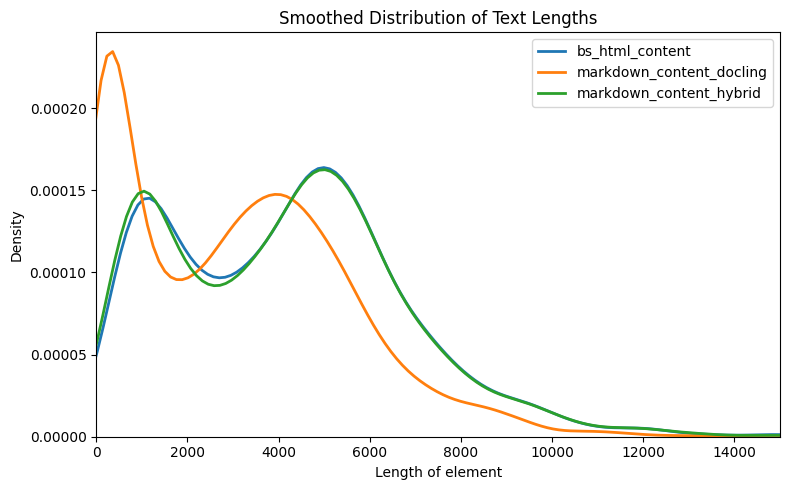

In [67]:
plt.figure(figsize=(8, 5))
cols = ['bs_html_content', 'markdown_content_docling', 'markdown_content_hybrid']

for col in cols:
    data = df[col].str.len().dropna()
    sns.kdeplot(data, label=col, linewidth=2)

plt.xlim(0, 15000)
plt.xlabel('Length of element')
plt.ylabel('Density')
plt.title('Smoothed Distribution of Text Lengths')
plt.legend()
plt.tight_layout()
plt.show()

#### Saving the data to storage

In [54]:
# Saving the Dataframe to the Google Drive storage
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-04-hybrid.csv'), index=False)

# 2. Multilingual Text Preprocessing and Cleaning

In [68]:
# For loading
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-04-hybrid.csv'))

## 2.1 Preprocessing

Perform necessary text preprocessing (e.g., removing extra spaces and redundant line breaks, normalizing
Unicode characters, standardizing date formats from different sources), and handle German-specific text
processing (e.g., compound words, umlaut normalization if needed)

In [69]:
df["markdown_content_hybrid"].head()

,markdown_content_hybrid
0,"Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Compute..."
1,"Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. ..."
2,Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon sparen. Ein an der ETH Zürich entwickeltes Sys...
3,"Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist nach wie vor gross: 241 ETH-Ange­hörige hab..."
4,Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Licht sehen. Im Podcast sprechen wir mit den ...


## 2.2 Metadata

Store the cleaned text and its metadata in a structured format suitable for retrieval (e.g., JSON, CSV, or a
database) with fields such as **language, title, date, source**

The following step enriches the dataframe by adding the date (month and year) extracted from the file path, as they are organized by date.

In [70]:
# Function to extract year and month from the folder path
def extract_year_month(path):

    if isinstance(path, str):  # Check if path is a string.
        parts = path.split('/')
        if len(parts) >= 2: # Check if the path has at least two parts
            month = parts[-1]
            year = parts[-2]
            return year, month
        else:
             return None, None
    else:
        return None, None #Handles the case where the input is not a string

# Apply the function to create new columns 'year' and 'month'
df[['year', 'month']] = df['folder_path'].apply(lambda x: pd.Series(extract_year_month(x)))


Extracts the type of document title and the language from the folder path structure.

In [71]:
def extract_language_type(path):
    if isinstance(path, str):
        parts = path.split('/')
        if len(parts) >= 4:  # Check for the third element from the end
            third_from_end = parts[-3]
            lang_type_parts = third_from_end.split('_')
            language = lang_type_parts[0] if lang_type_parts[0] in ('de', 'en') else None
            Type = 'internal' if len(lang_type_parts) > 1 and lang_type_parts[1] == 'internal' else \
                   'news events' if len(lang_type_parts) > 1 and lang_type_parts[1] == 'news' else None
            return language, Type
        else:
            return None, None
    else:
        return None, None

# Apply the function to create new columns 'language' and 'Type'
df[['language', 'type']] = df['folder_path'].apply(lambda x: pd.Series(extract_language_type(x)))

In [82]:
df[["bs_html_title"]].isna().sum()

,0
bs_html_title,4358


Below we extract the HTML file name and add it to the dataframe. This is necessary as many files do not contain a `<meta>` tag with the title or a `<h1>` tag for the title, as shown above.

In [72]:
# Function to extract and format the title from the file_name
def extract_and_format_title(file_name):
    """
    Extracts the title from the filename, removes the '.html' extension,
    replaces hyphens with spaces, and capitalizes only the first letter of the first word.

    Args:
        file_name (str): The filename.

    Returns:
        str: The formatted title, or None if the input is not a string.
    """
    if isinstance(file_name, str):
        title = file_name.replace(".html", "").replace("-", " ")
        words = title.split()
        if words:
            words[0] = words[0].capitalize()
            title = " ".join(words)
        return title
    else:
        return None

# Apply the function to create the 'html_title' column
df['html_title'] = df['file_name'].apply(extract_and_format_title)

In [74]:
# Print the updated DataFrame
df.head()

,folder_path,file_name,full_path,html_content,bs_html_title,bs_html_content,markdown_content_docling,markdown_content_hybrid,year,month,language,type,html_title
0,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08,blog-knutti-klimamodelle.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/blog-knutti-klimamodelle.html,"<div class=""text-image cq-dd-image"">\n<figure class=""text-image__image text-image__image--small"">\n<img alt=""Reto Knutti"" src=""/de/news-und-verans...",NaN,"Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Compute...",## Erstaunliche Entwicklung der Klimamodelle\n\nAuch die eng mit Wettermodellen verwandten Klimamodelle haben eine erstaunliche Entwicklung durchl...,"Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Compute...",2019,08,de,news events,Blog knutti klimamodelle
1,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08,scientifica-teaser-kerosin-aus-luft.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/scientifica-teaser-kerosin-aus-luft.html,"<div class=""text-image cq-dd-image"">\n<p>Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtägl...",NaN,"Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. ...","Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. ...","Vieles, womit sich Wissenschaftlerinnen und Wissenschaftler an der ETH und der Universität Zürich tagtäglich befassen, tönt nach Science Fiction. ...",2019,08,de,news events,Scientifica teaser kerosin aus luft
2,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08,kraftwerk-vor-dem-fenster.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/kraftwerk-vor-dem-fenster.html,"<div class=""text-image cq-dd-image"">\n<p>Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon spare...",NaN,Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon sparen. Ein an der ETH Zürich entwickeltes Sys...,"## Positive Energiebilanz\n\nArno Schlüter, Professor für Architektur und Gebäudesysteme, hat mit seiner Gruppe ein Fassadensystem entwickelt, mit...",Gebäude zu heizen oder zu kühlen benötigt Energie. Mit intelligenten Fassaden könnte man viel davon sparen. Ein an der ETH Zürich entwickeltes Sys...,2019,08,de,news events,Kraftwerk vor dem fenster
3,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08,eth-plus-initiativen.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/eth-plus-initiativen.html,"<div class=""text-image cq-dd-image"">\n<p>Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist na...",NaN,"Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist nach wie vor gross: 241 ETH-Ange­hörige hab...",## Materialien zum Leben erwecken\n\n<!-- image -->\n\nLebende Materialien werden in Zukunft an Bedeutung gewinnen. Doch noch sind viele Fragen of...,"Das Interesse an ETH+, in dessen Rahmen bereits letztes Jahr neun Initiativen an den Start gingen, ist nach wie vor gross: 241 ETH-Ange­hörige hab...",2019,08,de,news events,Eth plus initiativen
4,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08,kuenstliche-intelligenz-im-podcast.html,/content/drive/MyDrive/AdvGenAI/data/de_news_events/2019/08/kuenstliche-intelligenz-im-podcast.html,"<div class=""text-image cq-dd-image"">\n<p>Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intelligenz in einem neuen Lich...",NaN,Künstliche Intelligenz und maschinelles Lernen lassen uns die menschliche Intellig

In [83]:
print(df.columns)
# drop 'bs_html_content'and 'markdown_content_docling' columns
df1 = df.drop(columns=['bs_html_content', 'markdown_content_docling']).copy()
# remove the bs_html_title
df1 = df1.drop(columns=['bs_html_title'])
print(df1.columns)

Index(['folder_path', 'file_name', 'full_path', 'html_content',
       'bs_html_title', 'bs_html_content', 'markdown_content_docling',
       'markdown_content_hybrid', 'year', 'month', 'language', 'type',
       'html_title'],
      dtype='object')
Index(['folder_path', 'file_name', 'full_path', 'html_content',
       'markdown_content_hybrid', 'year', 'month', 'language', 'type',
       'html_title'],
      dtype='object')


In [88]:
# save file as csv
df1.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-05-metadata.csv'), index=False)

## 2.3 Preprocessing steps

In [ ]:
# load dataset
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-05-metadata.csv'))

Here we perform necessary text preprocessing (e.g., removing extra spaces and redundant line breaks, normalizing
Unicode characters, and handle German-specific text processing 'ß'.

We decided that there is no need to process and unify date structure as the date is already structured from the path of the files. We might lose some information regarding the day if included in some texts, but with a span of over a decade, that level of granularity won't be necessary.

Regarding the German specific processing such as umlaut or compound words:
- After normalizing unicode characters, we can see that umlauts and other characters are not an issue and are displayed properly, so there is no need for further processing. Natural Language Processing tools, embedding model and similar tools are able to handle the umlauts, and might even perform worse if they are exchanged. For this reason we decided not to process those characters.
- Compound words are an essential part of the German language, and processing it could affect negatively the meaning and understandability of the text explained, hence we decided against of processing them.

In [90]:
#print an example of the text in the markdown_content_hybrid column
print(df['markdown_content_hybrid'].iloc[0])

def preprocess_text(text):
	# Remove extra spaces and redundant line breaks
	text = re.sub(r'\s+', ' ', text)
	text = text.strip()

	# Normalize Unicode characters (if needed)
	text = text.encode('utf-8').decode('utf-8')

	# Handle German-specific text processing (e.g., compound words, umlaut normalization)
	text = text.replace('ß', 'ss')

	return text

# Apply the preprocessing function to the 'markdown_content_hybrid' column
df['content'] = df['markdown_content_hybrid'].progress_apply(preprocess_text)

print(df['content'].iloc[0])

Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Computer das Wetter simulierten, brauchten sie 24 Stunden Rechenzeit, um eine Prognose für 24 Stunden Wetter zu erstellen. Die Voraussage war dürftig, die Realität war schon eingetroffen und damit die Voraussage für niemanden brauchbar. Heute ist die Wetterprognose erstaunlich gut, oft bis eine Woche im Voraus und für extreme Ereignisse. Sie ist auf jedem Telefon verfügbar, und alle wissen, wie sie zu interpretieren ist.

## Erstaunliche Entwicklung der Klimamodelle

Auch die eng mit Wettermodellen verwandten Klimamodelle haben eine erstaunliche Entwicklung durchlaufen. Sie simulieren heute die Strömungen in der Atmosphäre und im Ozean, das Meereis, die Biosphäre und das Land, den Kohlenstoffkreislauf und vieles mehr. Klimamodelle berücksichtigen Tausende von Rückkopplungen und Prozesse des Klimas, umfassen eine Million Zeilen Programmcode, produzie

100%|██████████| 4358/4358 [00:01<00:00, 3958.67it/s]

Als 1950 die Meteorologen Jule Charney, Ragnar Fjørtoft und der Mathematiker John von Neumann zusammen mit anderen Forschenden erstmals am Computer das Wetter simulierten, brauchten sie 24 Stunden Rechenzeit, um eine Prognose für 24 Stunden Wetter zu erstellen. Die Voraussage war dürftig, die Realität war schon eingetroffen und damit die Voraussage für niemanden brauchbar. Heute ist die Wetterprognose erstaunlich gut, oft bis eine Woche im Voraus und für extreme Ereignisse. Sie ist auf jedem Telefon verfügbar, und alle wissen, wie sie zu interpretieren ist. ## Erstaunliche Entwicklung der Klimamodelle Auch die eng mit Wettermodellen verwandten Klimamodelle haben eine erstaunliche Entwicklung durchlaufen. Sie simulieren heute die Strömungen in der Atmosphäre und im Ozean, das Meereis, die Biosphäre und das Land, den Kohlenstoffkreislauf und vieles mehr. Klimamodelle berücksichtigen Tausende von Rückkopplungen und Prozesse des Klimas, umfassen eine Million Zeilen Programmcode, produziere

When inspecting the contents we discovered some passages that are present in multiple texts and give no value in the analysis ,like explaining the Staffnet portal or asking for sign-up to the newsletter. In the code below we replace some of those parts of the texts.

In [109]:
# List of texts to remove
remove_blocks = [
    """## Staffnet

Das Info-Portal für Mitarbeitende mit den wichtigsten Informationen rund um das Geschehen an der ETH Zürich.

## Newsletter abonnieren

Für Newsletter «Intern aktuell» anmelden""",
    """<!-- image -->""",
    """## Zum Autor

## Keinen Beitrag verpassen

Newsletter abonnieren""",
    """Newsletter abonnieren""",
    """## Subscribe to Newsletter

Subscribe to the Newsletter for internal news

## Staffnet

Info portal for employees with the key information about what’s going on at ETH Zurich.""",
    """call\_made""",
    """externe Seite""",
    """## Keine News verpassen

Abonnieren Sie den internen Newsletter""",
    """## Keinen Beitrag verpassen""",
    """## Keine News verpassen""",
    """## Don't miss a post

Sign up for our newsletter"""]

In [104]:
# Remove all blocks in the list from the texts
for block in remove_blocks:
    df['content'] = df['content'].str.replace(block, '', regex=False)

In [105]:
# Remove excessive newlines

def replace_excessive_newlines(text):
  return re.sub(r'\n{3,}', '\n\n', text)

df['content'] = df['content'].apply(replace_excessive_newlines)

In [107]:
# save file as csv
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-06-preprocessed.csv'), index=False)

## 2.4 Metadata Extraction from Content (NLP)

In the following steps, information about the text will be extracted and added as metadata to the dataframe, fields such as **main content, named entities, topics, keywords, summary**

In [108]:
# load dataset
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-06-preprocessed.csv'))

The next step processes the (`content` column) and its language (`language` column)to perform the following tasks:

1. **Loads NLP Models**: Initializes spaCy models for English and German text processing.
2. **Extracts Features**: Defines a function `extract_all` to extract:
   - Named entities using spaCy.
   - Keywords using KeyBERT.
   - Topics using Gensim's LDA.
   - A summary (heuristic: two longest sentences).
3. **Applies the Function**: Processes each row of the DataFrame using `progress_apply` and adds the extracted features as new columns (`named_entities`, `topics`, `keywords`, `summary`).
4. **Displays Results**: Prints the first few rows of the updated DataFrame.

In [ ]:
# --- Install required packages if needed ---
# pip install spacy keybert gensim tqdm
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm

import pandas as pd
import spacy
from keybert import KeyBERT
from gensim import corpora, models
from tqdm import tqdm

# Load spaCy models
nlp_en = spacy.load("en_core_web_sm")
nlp_de = spacy.load("de_core_news_sm")

# Init KeyBERT
kw_model = KeyBERT()

# Enable progress_apply
tqdm.pandas()

# --- Define the extraction function ---
def extract_all(text, lang):
    # Select language-specific spaCy model
    if lang == "de":
        nlp = nlp_de
    else:
        nlp = nlp_en

    doc = nlp(text)

    # Named Entities
    entities = list(set((ent.text, ent.label_) for ent in doc.ents))

    # Keywords
    keywords = kw_model.extract_keywords(text, top_n=5)
    keywords = [kw[0] for kw in keywords]

    # Topics using LDA (via Gensim)
    tokens = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]
    dictionary = corpora.Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]
    try:
        lda_model = models.LdaModel(corpus, num_topics=1, id2word=dictionary, passes=4)
        topics = [word for word, _ in lda_model.show_topic(0)]
    except:
        topics = []

    # Summary (heuristic: longest 2 sentences)
    sentences = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 20]
    sentences = sorted(sentences, key=lambda s: len(s), reverse=True)
    summary = " ".join(sentences[:2]) if sentences else ""

    return pd.Series({
        "named_entities": entities,
        "topics": topics,
        "keywords": keywords,
        "summary": summary
    })

# --- Apply it to your DataFrame ---
# Make sure your df has 'content' and 'language' columns
df = df.dropna(subset=["content", "language"])
df[["named_entities", "topics", "keywords", "summary"]] = df.progress_apply(
    lambda row: extract_all(row["content"], row["language"]),
    axis=1
)

# Optional: display result
print(df[["content", "language", "named_entities", "topics", "keywords", "summary"]].head())


In [ ]:
# save the updated dataframe to a new CSV file
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-06-NLP-processed.csv'), index=False)

In [ ]:
# load dataset
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-06-NLP-processed.csv'))

## 2.5 Evaluation of Summary

This code uses `sumy` library to extract the summary from the `content` using Latent Semantic Analysis (LSA). Tt processes the text content, applies the `LsaSummarizer` to extract key sentences based on topic relevance, and removes stop words to enhance readability. The summarization function is then applied to each row in the DataFrame, creating a new column with summarized text

In [ ]:
import pandas as pd
from sumy.parsers.plaintext import PlaintextParser  # Corrected import
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.utils import get_stop_words

import nltk
nltk.download('punkt_tab')

# Function to summarize text based on language
i=0
def summarize_text(row):
    global i
    language = row["language"]
    parser = PlaintextParser.from_string(row["content"], Tokenizer(language))  # Corrected usage
    summarizer = LsaSummarizer()
    summarizer.stop_words = get_stop_words(language)

    summary_sentences = summarizer(parser.document, 2)  # Get top 2 sentences
    i=i+1
    print(i)
    return " ".join([str(sentence) for sentence in summary_sentences])

# Apply summarization
df["summary_summy"] = df.apply(summarize_text, axis=1)

print(df)


In [ ]:
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-07-summaryv2.csv'), index=False)

In [ ]:
# load dataset
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-07-summaryv2.csv'))
print(df.columns)

In [ ]:
!pip install bert_score

In [ ]:
import pandas as pd
from bert_score import score

# Make sure content and summaries are strings
df = df.dropna(subset=['content', 'summary', 'summary_summy'])
contents = df['content'].astype(str).tolist()
summaries_1 = df['summary'].astype(str).tolist()
summaries_2 = df['summary_summy'].astype(str).tolist()

# Compute BERTScore (Precision, Recall, F1) for both sets of summaries
P1, R1, F1 = score(summaries_1, contents, lang="en", verbose=True)
P2, R2, F2 = score(summaries_2, contents, lang="en", verbose=True)

# Add results to DataFrame
df['bertscore_summary_f1'] = F1.tolist()
df['bertscore_summy_f1'] = F2.tolist()

# Compare average F1 scores
mean_f1_summary = F1.mean().item()
mean_f1_summy = F2.mean().item()

print(f"Mean BERTScore F1 - summary:      {mean_f1_summary:.4f}")
print(f"Mean BERTScore F1 - summary_summy: {mean_f1_summy:.4f}")

The result of comparing both summaries ends in a tie:
- Mean BERTScore F1 - summary:      0.8648
- Mean BERTScore F1 - summary_summy: 0.8640

In [ ]:
# filter the dataframe by 'language' = 'en' and take 10 random samples with a fixed seed
sample = df[df['language'] == 'en'].sample(10, random_state=42)[['summary', 'summary_summy']]

# print the samples in pairs
for i, row in sample.iterrows():
	print(f"Summary: {row['summary']}")
	print(f"Summy: {row['summary_summy']}")
	print()

The heuristic-based approach selects the longest sentences, assuming they are the most relevant, but often fails to capture the true essence of the content, producing long chunks without contextual analysis.

In contrast, summy uses advanced algorithms to extract meaningful sentences, creating concise and focused summaries based on the data. When summaries differ, summy consistently provides more context-aware and coherent outputs by inferring importance rather than relying on sentence length.

While both methods may achieve similar BERT scores, summy demonstrates a deeper understanding of the content, producing summaries that are both accurate and contextually meaningful.

Hence we will keep only the sumy summary and delete the helper columns on the dataframe

In [ ]:
# Load again the dataset to avoid deleting several columns created in the previous steps
df = pd.read_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-07-summaryv2.csv'))

# Delete 'summary' column
df.drop(columns=['summary'], inplace=True)

# rename column 'summary_summy' to summary
df.rename(columns={'summary_summy': 'summary'}, inplace=True)
print(df.columns)



In [ ]:
df.to_csv(os.path.join(base_folder, 'Stage1/Working-dir/Stage1-08-final.csv'), index=False)